<IPython.core.display.Javascript object>


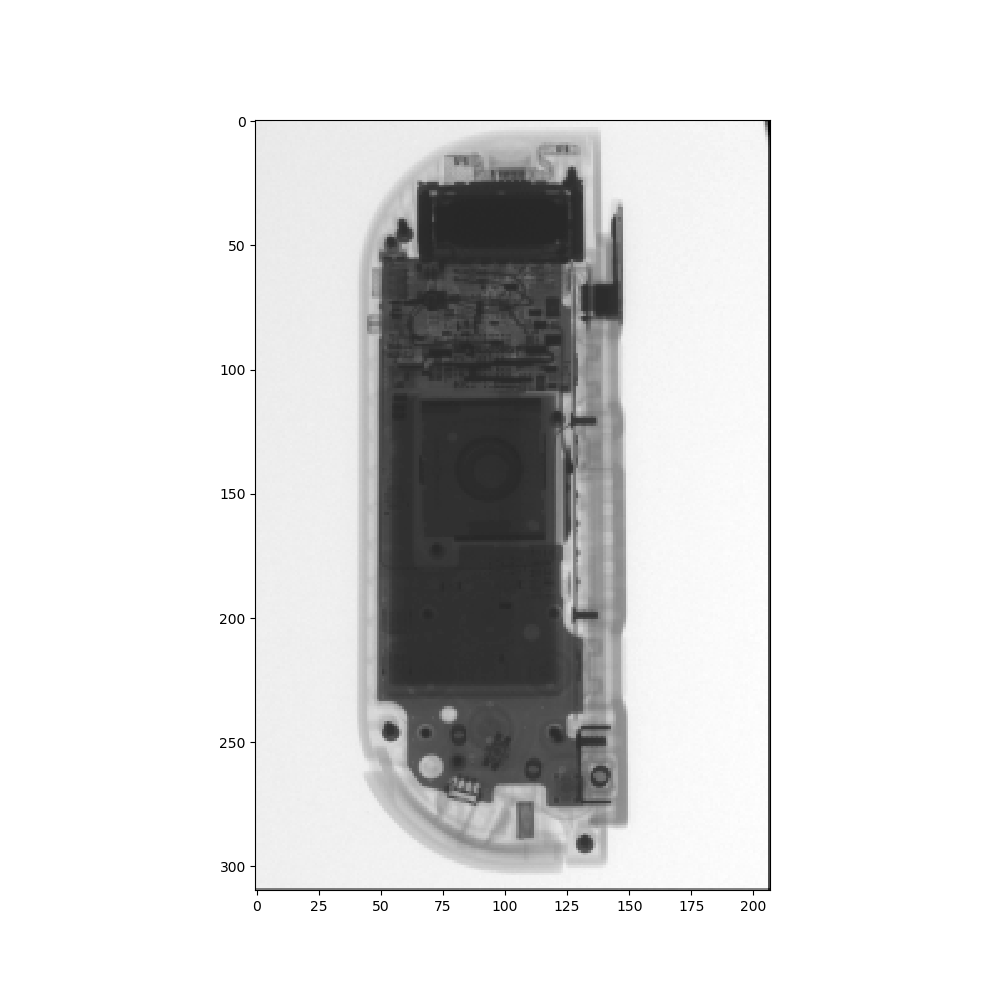

In [41]:
%matplotlib notebook

import glob
import random
import re

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from skimage import img_as_uint, img_as_ubyte, data
from skimage.io import imread, imsave
from skimage.feature import ORB, match_descriptors, CENSURE, plot_matches
from skimage.transform import downscale_local_mean, ProjectiveTransform, warp, SimilarityTransform, rotate
from skimage.measure import ransac
from skimage.exposure import rescale_intensity
from skimage.measure import label

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, clear_output
import ipywidgets as widgets

import numpy as np

import cv2
images = []

plt.rcParams['image.cmap'] = 'gray'

# load images and its exposure
for filename in glob.glob('./stitching_frames4/*.tiff'):
    images.append(downscale_local_mean(imread(filename, as_grey=True), (5, 5)).astype(np.uint16))
    #images.append(imread(filename, as_grey=True))
plt.figure(figsize=(10, 10))
plt.imshow((images[0]))

# Merge base image with first image

In [73]:
def stitch_images(dst, src):
    orb = ORB(n_keypoints=500, fast_threshold=0.05, fast_n=15)
    orb.detect_and_extract(dst)
    dest_desc = orb.descriptors
    dest_key_pts = orb.keypoints

    orb.detect_and_extract(src)
    src_desc = orb.descriptors
    src_key_pts = orb.keypoints 
    matches = match_descriptors(dest_desc, src_desc, cross_check=True)

     # match and find inliers and model
    src_pts = src_key_pts[matches[:, 1]][:, ::-1]
    dst_pts = dest_key_pts[matches[:, 0]][:, ::-1]
    model, inliers = ransac((src_pts, dst_pts), ProjectiveTransform,
                             min_samples=10, residual_threshold=2)

    # warp
    r, c = dst.shape[:2]
    corners = np.array([[0, 0], [0, r], [c, 0], [c, r]])
    warped_corners = model(corners)
    all_corners = np.vstack((warped_corners, corners))

    corner_min = np.min(all_corners, axis=0)
    corner_max = np.max(all_corners, axis=0)
    output_shape = (corner_max - corner_min)
    output_shape += np.abs(corner_min)
    output_shape = output_shape[::-1].astype(np.int)

    base_offset = SimilarityTransform(translation=-corner_min)
    dst_image = warp(dst, base_offset.inverse, output_shape=output_shape, cval=-1)

    src_image = warp(src, (model + base_offset).inverse,
                     output_shape=output_shape, cval=-1)

    dst_image_mask = (dst_image != -1)
    src_image_mask = (src_image != -1)
    dst_image[~dst_image_mask] = 0
    src_image[~src_image_mask] = 0

    overflow_mask = (dst_image_mask.astype(int) + src_image_mask.astype(int))
    
    mask = np.zeros_like(dst_image, dtype=np.float32)
    
    print(dst_image)
    result_image = Laplacian_Pyramid_Blending_with_mask(dst_image, src_image, src_image_mask.astype(int), 5)
    return result_image

def Laplacian_Pyramid_Blending_with_mask(A, B, m, num_levels = 6):
    # assume mask is float32 [0,1]

    # generate Gaussian pyramid for A,B and mask
    GA = A.copy()
    GB = B.copy()
    GM = m.copy()
    gpA = [GA]
    gpB = [GB]
    gpM = [GM]
    for i in range(num_levels):
        GA = cv2.pyrDown(GA)
        GB = cv2.pyrDown(GB)
        GM = cv2.pyrDown(GM)
        gpA.append(np.float32(GA))
        gpB.append(np.float32(GB))
        gpM.append(np.float32(GM))

    # generate Laplacian Pyramids for A,B and masks
    lpA  = [gpA[num_levels-1]] # the bottom of the Lap-pyr holds the last (smallest) Gauss level
    lpB  = [gpB[num_levels-1]]
    gpMr = [gpM[num_levels-1]]
    for i in range(num_levels-1,0,-1):
        # Laplacian: subtarct upscaled version of lower level from current level
        # to get the high frequencies
        LA = np.subtract(gpA[i-1], cv2.pyrUp(gpA[i]))
        LB = np.subtract(gpB[i-1], cv2.pyrUp(gpB[i]))
        lpA.append(LA)
        lpB.append(LB)
        gpMr.append(gpM[i-1]) # also reverse the masks

    # Now blend images according to mask in each level
    LS = []
    for la,lb,gm in zip(lpA,lpB,gpMr):
        ls = la * gm + lb * (1.0 - gm)
        LS.append(ls)

    # now reconstruct
    ls_ = LS[0]
    for i in range(1,num_levels):
        ls_ = cv2.pyrUp(ls_)
        ls_ = cv2.add(ls_, LS[i])

    return ls_
merged = stitch_images(images[1], images[0])

# merge other images to first one
for image in images[2:]:
    merged = stitch_images(merged, image)
    
plt.figure(figsize=(10, 10))
plt.imshow(merged)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


error: C:\projects\opencv-python\opencv\modules\imgproc\src\pyramids.cpp:1383: error: (-210)  in function cv::pyrDown


## Feature detection and matching

Base offset:<skimage.transform._geometric.SimilarityTransform object at 0x000001DEB5864400>
Result image shape (315, 299)
Base offset:<skimage.transform._geometric.SimilarityTransform object at 0x000001DEB75FE1D0>
Result image shape (315, 593)
[315 593]
(315, 593)
(315, 593)
(315, 593)


<IPython.core.display.Javascript object>


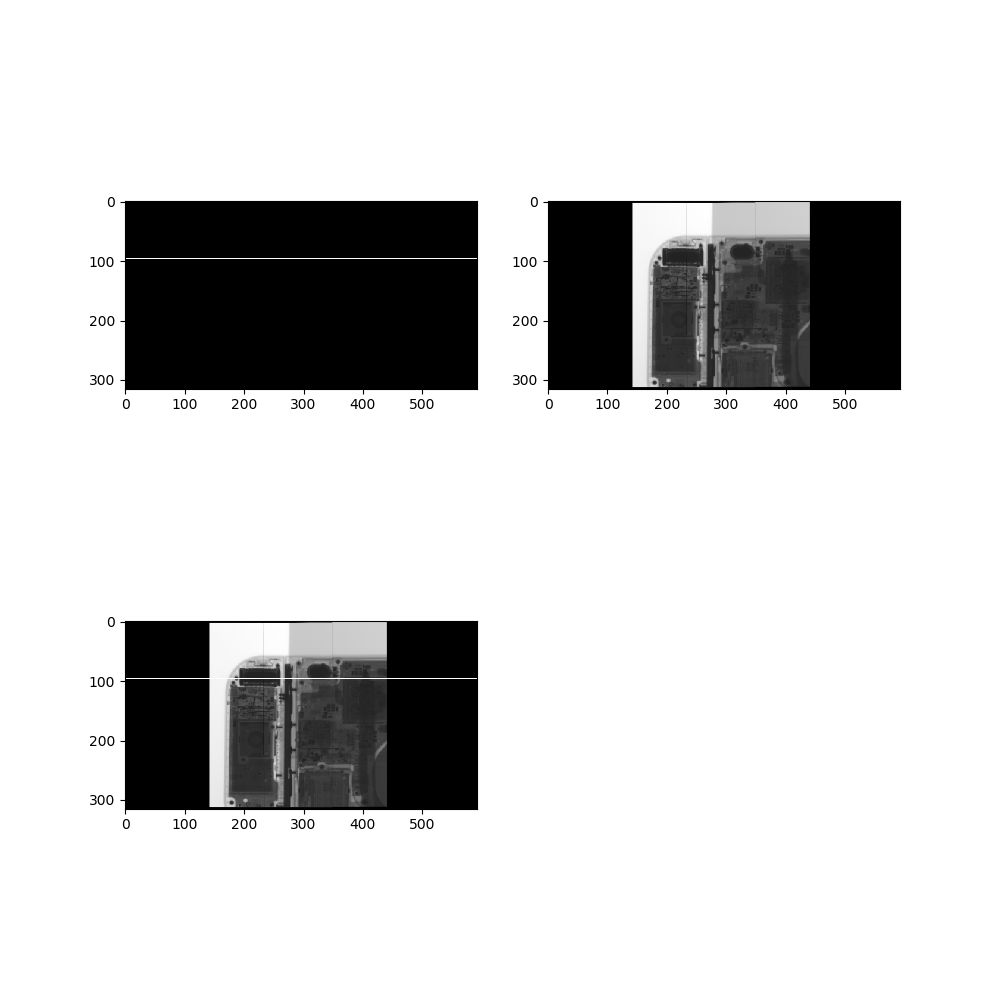

<IPython.core.display.Javascript object>


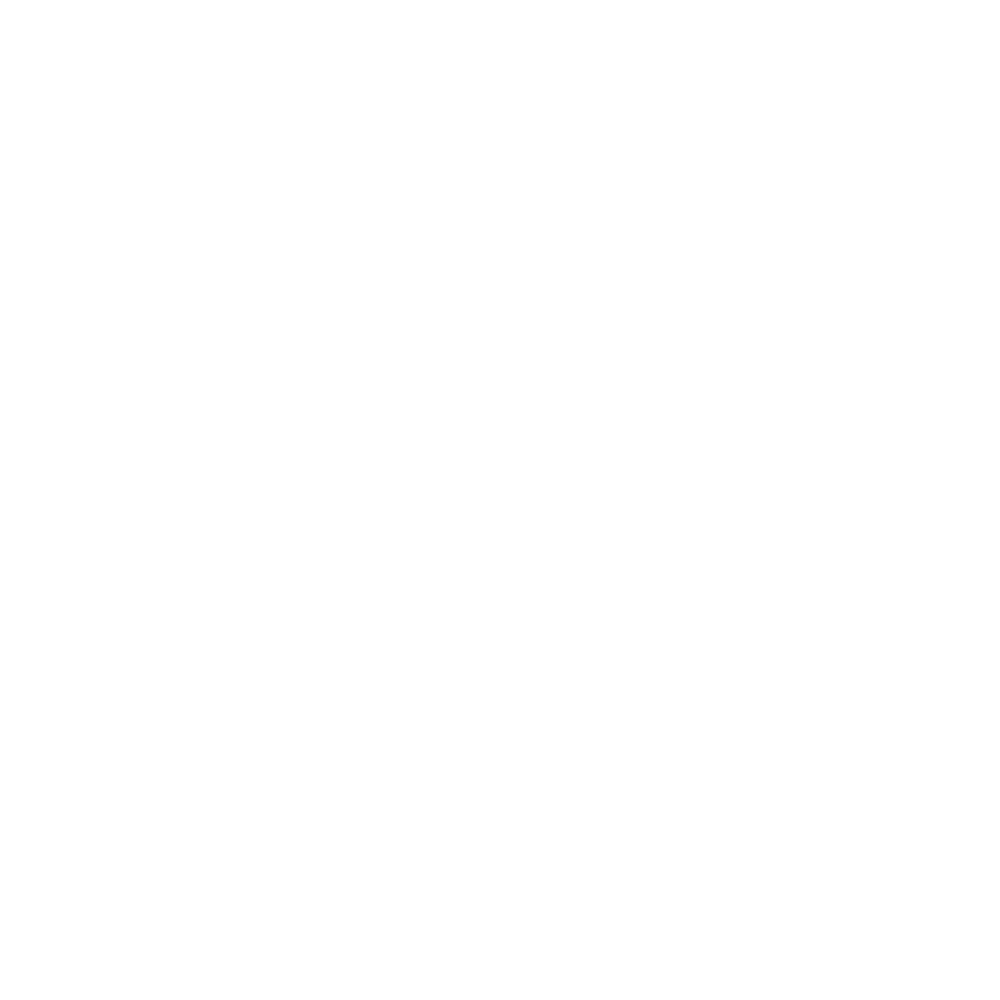

<IPython.core.display.Javascript object>


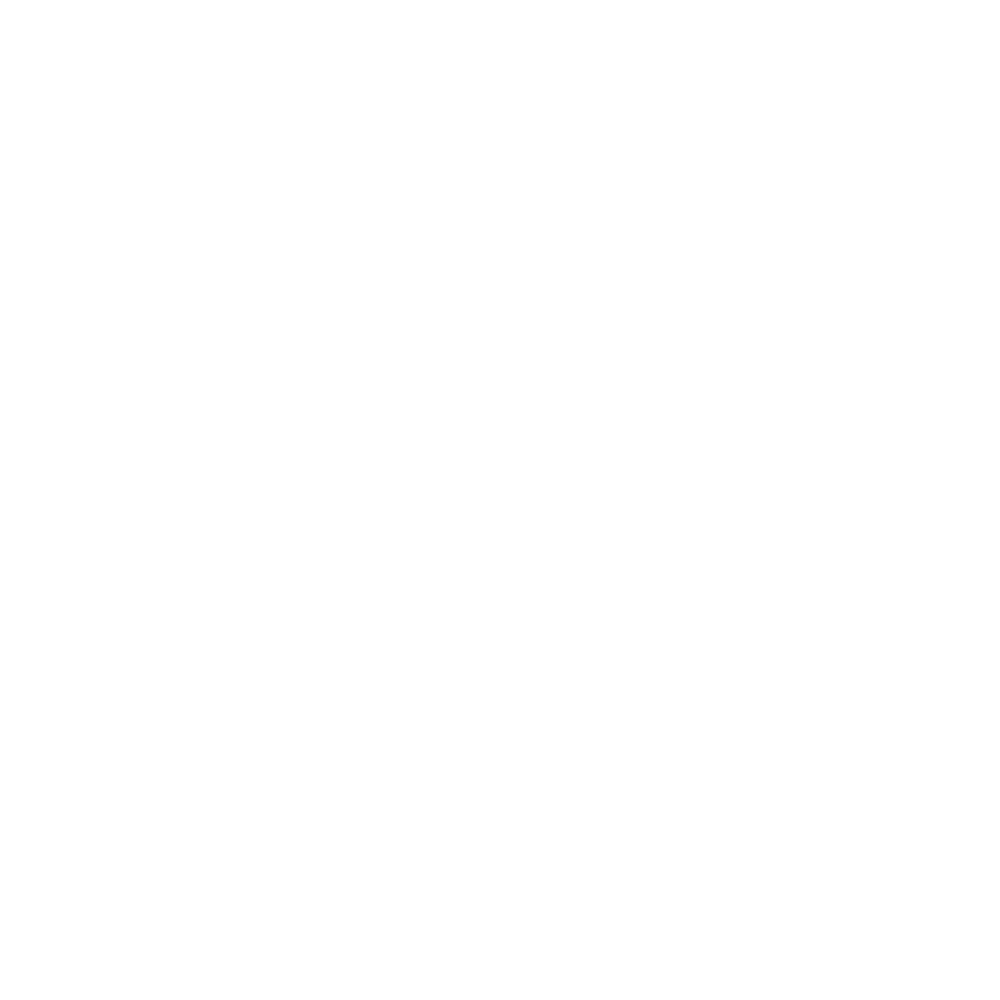

In [36]:
images_dict = []
images_left = []

keypoints = []
descriptors = []
matches = []

# find keypoints and descriptors
for image in images:
    image = gaussian(image, sigma=2)
       
result_image = images[0]


for image in images[1:3]:
    
    # find best image
    orb = ORB(n_keypoints=1000, fast_threshold=0.05, fast_n=15)
    orb.detect_and_extract(rescale_intensity(image))
    src_desc = orb.descriptors
    src_key_pts = orb.keypoints
    
    temp_image = result_image
    
    orb.detect_and_extract(rescale_intensity(result_image))
    dest_desc = orb.descriptors
    dest_key_pts = orb.keypoints
    
    # match and find inliers and model
    matches = match_descriptors(dest_desc, src_desc, cross_check=True)
    src = src_key_pts[matches[:, 1]][:, ::-1]
    dst = dest_key_pts[matches[:, 0]][:, ::-1]
    model, inliers = ransac((src, dst), ProjectiveTransform,
                     min_samples=10, residual_threshold=2)

    # warp
    r, c = result_image.shape[:2]
    corners = np.array([[0, 0], [0, r], [c, 0], [c, r]])
    warped_corners = model(corners)
    all_corners = np.vstack((warped_corners, corners))
    
    
    corner_min = np.min(all_corners, axis=0)
    corner_max = np.max(all_corners, axis=0)
    output_shape = (corner_max - corner_min)
    output_shape += np.abs(corner_min)
    output_shape = output_shape[::-1].astype(np.int)
    
    base_offset = SimilarityTransform(translation=-corner_min)
    print(f"Base offset:{base_offset}")
    dst_image = warp(result_image, base_offset.inverse, output_shape=output_shape, cval=-1)
    
    src_image = warp(image, (model + base_offset).inverse,
                     output_shape=output_shape, cval=-1)
    
    dst_image_mask = (dst_image != -1)
    src_image_mask = (src_image != -1)
    dst_image[~dst_image_mask] = 0
    src_image[~src_image_mask] = 0

    overflow_mask = (dst_image_mask.astype(int) + src_image_mask.astype(int))
    result_image = ((dst_image + src_image) / np.maximum(overflow_mask, 1))
    print(f"Result image shape {result_image.shape}")

print(output_shape)
print(dst_image.shape)
print(src_image.shape)
print(result_image.shape)

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(src_image)
plt.subplot(222)
plt.imshow(dst_image)
plt.subplot(223)
plt.imshow(result_image)

plt.figure(figsize=(10,10))
#plot_matches(plt.gca(), image, temp_image, src_key_pts, dest_key_pts, matches)
#print(base_image)